In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/My Drive/Colab Notebooks/two_stage_af_pred/")

Mounted at /content/drive


30 Minutes window Training and Evaluation

Train: (949, 1800)
Val: (272, 1800)
Test: (273, 1800)
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Best threshold: 0.1251
Sensitivity (Recall): 0.8387
Specificity: 0.8760
Precision: 0.4643
F1 Score (weighted): 0.8867
AUPRC: 0.7367
AUROC: 0.9103
              precision    recall  f1-score   support

           0       0.98      0.88      0.92       242
           1       0.46      0.84      0.60        31

    accuracy                           0.87       273
   macro avg       0.72      0.86      0.76       273
weighted avg       0.92      0.87      0.89       273



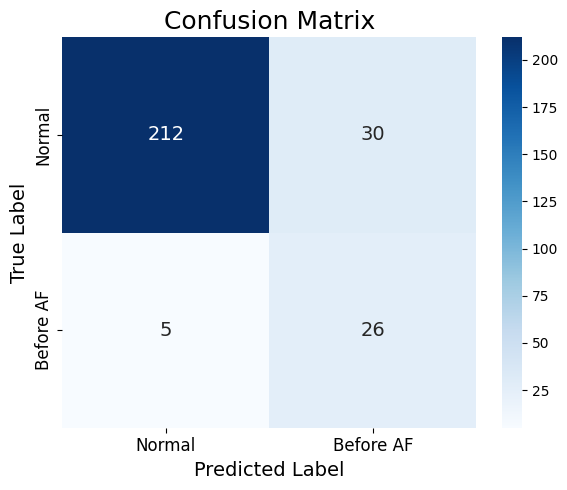

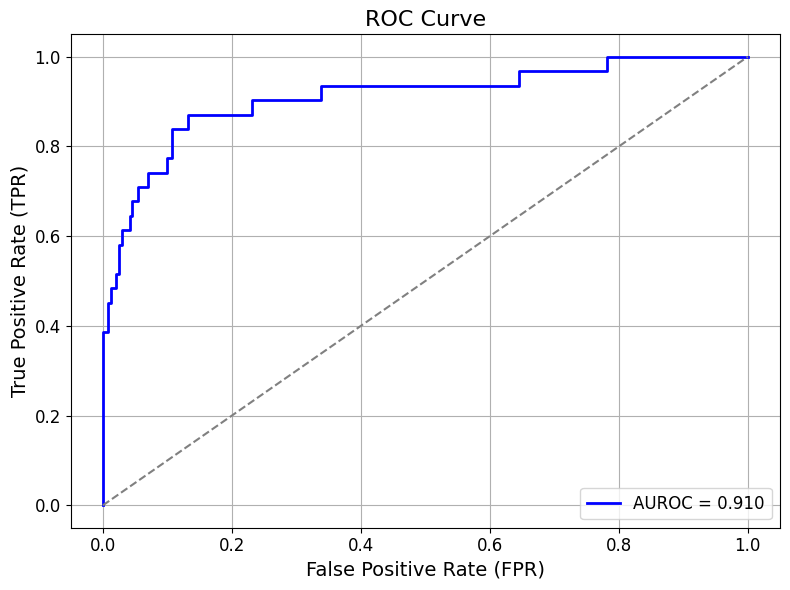

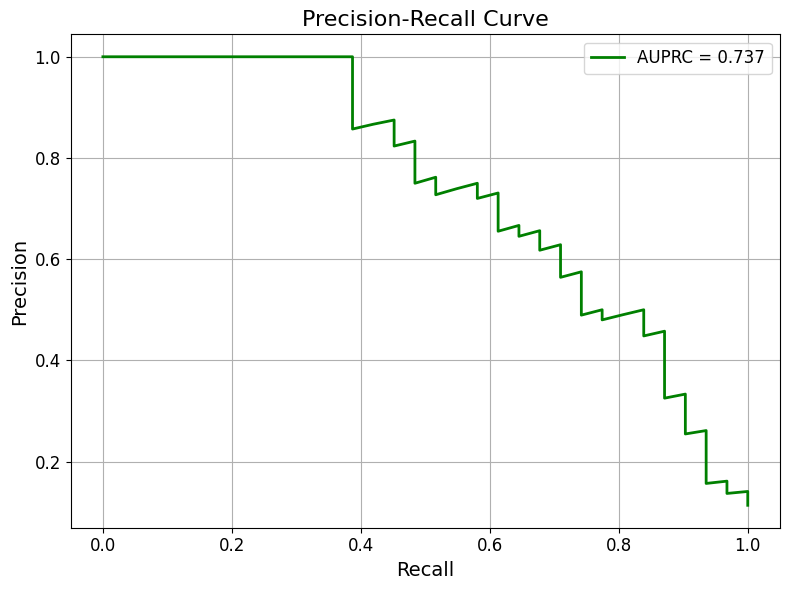

In [12]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, Dense, Dropout,
    Add, Bidirectional, LSTM
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping

def residual_block_newrri(inputs, filters=32, kernel_size=3, dropout_rate=0.2):
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding="same")(x)
    x = BatchNormalization()(x)

    shortcut = Conv1D(filters=filters, kernel_size=kernel_size, padding="same")(inputs)
    shortcut = BatchNormalization()(shortcut)

    output = Add()([x, shortcut])
    output = ReLU()(output)

    return output

def build_newrri_model(input_shape=(600, 1)):

    inputs = Input(shape=input_shape)

    x = Conv1D(filters=16, kernel_size=11, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = residual_block_newrri(x, filters=32, kernel_size=3, dropout_rate=0.2)
    x = residual_block_newrri(x, filters=32, kernel_size=3, dropout_rate=0.2)
    x = residual_block_newrri(x, filters=64, kernel_size=3, dropout_rate=0.2)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(128))(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

def subject_split(data, label, subject, val_size=0.2, test_size=0.2, seed=42):
    unique_subjects = np.unique(subject)
    train_subj, temp_subj = train_test_split(unique_subjects, test_size=(val_size + test_size), random_state=seed, shuffle=True)
    val_subj, test_subj = train_test_split(temp_subj, test_size=test_size / (val_size + test_size), random_state=seed, shuffle=True)

    train_idx = np.isin(subject, train_subj)
    val_idx = np.isin(subject, val_subj)
    test_idx = np.isin(subject, test_subj)

    return {
        'train': (data[train_idx], label[train_idx], subject[train_idx]),
        'val': (data[val_idx], label[val_idx], subject[val_idx]),
        'test': (data[test_idx], label[test_idx], subject[test_idx]),
    }

seed = 79
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Load .mat data (Preprocessed by matlab)
data_path = os.path.join(os.getcwd(), 'Data/data_RRI_short_term_30min_final.mat')
data = loadmat(data_path)

# Load all datasets
datasets = [
    {'data': data['train_data'], 'label': data['train_label'].flatten()},
    {'data': data['train2_data'], 'label': data['train2_label'].flatten()},
    {'data': data['train3_data'], 'label': data['train3_label'].flatten()},
    {'data': data['train4_data'], 'label': data['train4_label'].flatten(), 'subject': data['train4_subject'].flatten()},
    {'data': data['train5_data'], 'label': data['train5_label'].flatten(), 'subject': data['train5_subject'].flatten()},
]

# Split train4 and train5 subject-wise
split_train4 = subject_split(datasets[3]['data'], datasets[3]['label'], datasets[3]['subject'], val_size=0.2, test_size=0.2, seed=seed)
split_train5 = subject_split(datasets[4]['data'], datasets[4]['label'], datasets[4]['subject'], val_size=0.2, test_size=0.2, seed=seed)

# Save subject numbers
val_subjects = np.unique(np.concatenate([split_train4['val'][2], split_train5['val'][2]]))
test_subjects = np.unique(np.concatenate([split_train4['test'][2], split_train5['test'][2]]))

# Final splits
train_data = np.concatenate([
    datasets[0]['data'],
    datasets[1]['data'],
    datasets[2]['data'],
    split_train4['train'][0],
    split_train5['train'][0]
], axis=0)
train_label = np.concatenate([
    datasets[0]['label'],
    datasets[1]['label'],
    datasets[2]['label'],
    split_train4['train'][1],
    split_train5['train'][1]
], axis=0)

val_data = np.concatenate([split_train4['val'][0], split_train5['val'][0]], axis=0)
val_label = np.concatenate([split_train4['val'][1], split_train5['val'][1]], axis=0)

test_data = np.concatenate([split_train4['test'][0], split_train5['test'][0]], axis=0)
test_label = np.concatenate([split_train4['test'][1], split_train5['test'][1]], axis=0)

# Debug Train and Val
print("Train:", train_data.shape)
print("Val:", val_data.shape)
print("Test:", test_data.shape)

# Upsample the training data
ros = RandomOverSampler(random_state=seed)
x_train_final, y_train_final = ros.fit_resample(train_data, train_label)

# Reshape for train
x_train_final = x_train_final.reshape((-1, 1800, 1))
x_valid = val_data.reshape((-1, 1800, 1))
y_valid = val_label
x_test = test_data.reshape((-1, 1800, 1))
y_test = test_label

# Build and compile the model
model = build_newrri_model(input_shape=(1800, 1))

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
# history = model.fit(
#     x_train_final, y_train_final,
#     validation_data=(x_valid, y_valid),
#     epochs=300,
#     batch_size=32,
#     verbose=1,
#     callbacks=[early_stopping],
#     shuffle=True
# )

# Load Model already trained
model.load_weights('Models/model_30min_final.h5')

# Save the final trained model
# np.savez(f'Models/data_30min_final.npz',
#          X_train=x_train_final,
#          y_train=y_train_final,
#          val_subjects=val_subjects,
#          test_subjects=test_subjects,
#          X_valid=x_valid,
#          y_valid=y_valid,
#          X_test=x_test,
#          y_test=y_test)
# model.save(f'Models/model_30min_final.h5')

# Predict probabilities on validation set
val_prob = model.predict(x_valid)
val_scores = val_prob[:, 1]
val_true = y_valid

# Predict probabilities on test set
y_prob = model.predict(x_test)
y_scores = y_prob[:, 1]
y_true = y_test

fpr, tpr, roc_thresholds = roc_curve(val_true, val_scores)
youden_j = tpr - fpr
best_roc_idx = np.argmax(youden_j)
best_threshold = roc_thresholds[best_roc_idx]

print(f"Best threshold: {best_threshold:.4f}")

# Apply best threshold from validation
y_pred = (y_scores >= best_threshold).astype(int)

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_true, y_scores)
auprc = auc(rec, prec)

# Metrics
sensitivity = recall_score(y_true, y_pred)
specificity = recall_score(y_true, y_pred, pos_label=0)
precision_val = precision_score(y_true, y_pred)
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Accuracy Matrix
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"AUPRC: {auprc:.4f}")
print(f"AUROC: {roc_auc:.4f}")

# Classification Report
print(classification_report(y_true, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
ax = sns.heatmap(confusion_matrix(y_true, y_pred),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Before AF'],
                yticklabels=['Normal', 'Before AF'],
                annot_kws={"size": 14})
ax.set_title("Confusion Matrix", fontsize=18)
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()


# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUROC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('ROC Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

# AUPRC
plt.figure(figsize=(8, 6))
plt.plot(rec, prec, color='green', lw=2, label=f'AUPRC = {auprc:.3f}')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

15 Minutes window Training and Evaluation

Train: (2612, 900)
Val: (544, 900)
Test: (546, 900)
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Best threshold: 0.4282
Sensitivity (Recall): 0.7419
Specificity: 0.9421
Precision: 0.6216
F1 Score (weighted): 0.9225
AUPRC: 0.8108
AUROC: 0.9189
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       484
           1       0.62      0.74      0.68        62

    accuracy                           0.92       546
   macro avg       0.79      0.84      0.82       546
weighted avg       0.93      0.92      0.92       546



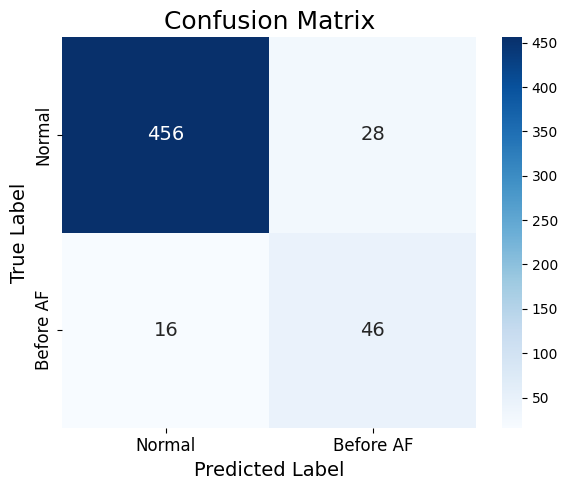

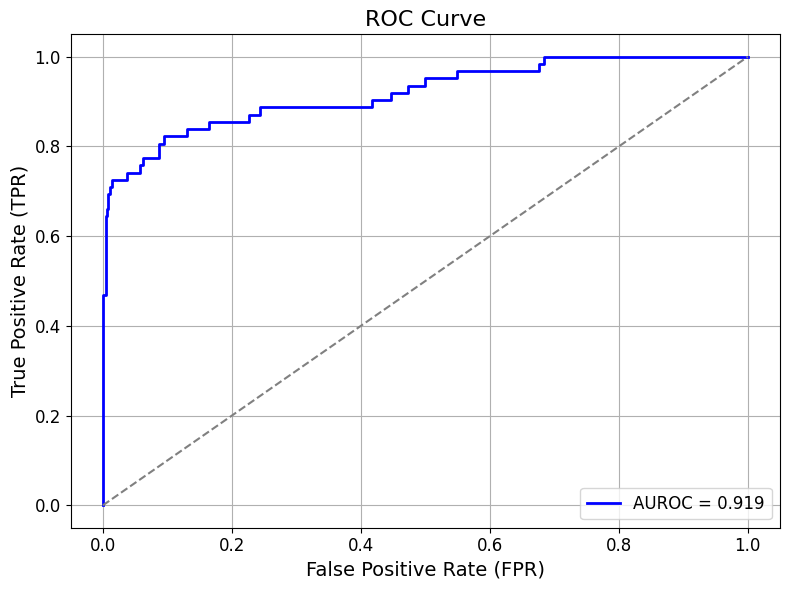

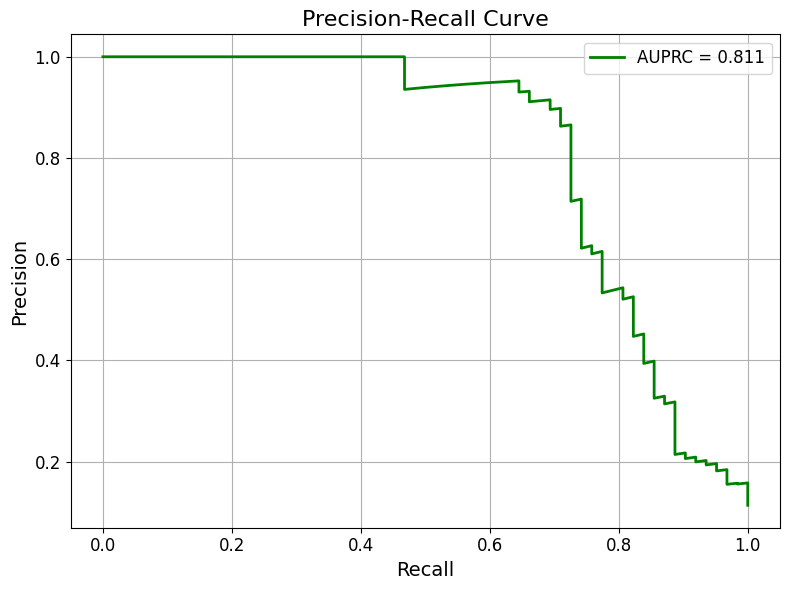

In [13]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, Dense, Dropout,
    Add, Bidirectional, LSTM
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping

def residual_block_newrri(inputs, filters=32, kernel_size=3, dropout_rate=0.2):
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding="same")(x)
    x = BatchNormalization()(x)

    shortcut = Conv1D(filters=filters, kernel_size=kernel_size, padding="same")(inputs)
    shortcut = BatchNormalization()(shortcut)

    output = Add()([x, shortcut])
    output = ReLU()(output)

    return output

def build_newrri_model(input_shape=(600, 1)):

    inputs = Input(shape=input_shape)

    x = Conv1D(filters=16, kernel_size=11, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = residual_block_newrri(x, filters=32, kernel_size=3, dropout_rate=0.2)
    x = residual_block_newrri(x, filters=32, kernel_size=3, dropout_rate=0.2)
    x = residual_block_newrri(x, filters=64, kernel_size=3, dropout_rate=0.2)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(128))(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

def subject_split(data, label, subject, val_size=0.2, test_size=0.2, seed=42):
    unique_subjects = np.unique(subject)
    train_subj, temp_subj = train_test_split(unique_subjects, test_size=(val_size + test_size), random_state=seed, shuffle=True)
    val_subj, test_subj = train_test_split(temp_subj, test_size=test_size / (val_size + test_size), random_state=seed, shuffle=True)

    train_idx = np.isin(subject, train_subj)
    val_idx = np.isin(subject, val_subj)
    test_idx = np.isin(subject, test_subj)

    return {
        'train': (data[train_idx], label[train_idx], subject[train_idx]),
        'val': (data[val_idx], label[val_idx], subject[val_idx]),
        'test': (data[test_idx], label[test_idx], subject[test_idx]),
    }


seed = 79
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Load .mat data (Preprocessed by matlab)
data_path = os.path.join(os.getcwd(), 'Data/data_RRI_short_term_15min_final.mat')
data = loadmat(data_path)

# Load all datasets
datasets = [
    {'data': data['train_data'], 'label': data['train_label'].flatten()},
    {'data': data['train2_data'], 'label': data['train2_label'].flatten()},
    {'data': data['train3_data'], 'label': data['train3_label'].flatten()},
    {'data': data['train4_data'], 'label': data['train4_label'].flatten(), 'subject': data['train4_subject'].flatten()},
    {'data': data['train5_data'], 'label': data['train5_label'].flatten(), 'subject': data['train5_subject'].flatten()},
]

# Split train4 and train5 subject-wise
split_train4 = subject_split(datasets[3]['data'], datasets[3]['label'], datasets[3]['subject'], val_size=0.2, test_size=0.2, seed=seed)
split_train5 = subject_split(datasets[4]['data'], datasets[4]['label'], datasets[4]['subject'], val_size=0.2, test_size=0.2, seed=seed)

# Save subject numbers
val_subjects = np.unique(np.concatenate([split_train4['val'][2], split_train5['val'][2]]))
test_subjects = np.unique(np.concatenate([split_train4['test'][2], split_train5['test'][2]]))

# Final splits
train_data = np.concatenate([
    datasets[0]['data'],
    datasets[1]['data'],
    datasets[2]['data'],
    split_train4['train'][0],
    split_train5['train'][0]
], axis=0)
train_label = np.concatenate([
    datasets[0]['label'],
    datasets[1]['label'],
    datasets[2]['label'],
    split_train4['train'][1],
    split_train5['train'][1]
], axis=0)

val_data = np.concatenate([split_train4['val'][0], split_train5['val'][0]], axis=0)
val_label = np.concatenate([split_train4['val'][1], split_train5['val'][1]], axis=0)

test_data = np.concatenate([split_train4['test'][0], split_train5['test'][0]], axis=0)
test_label = np.concatenate([split_train4['test'][1], split_train5['test'][1]], axis=0)

# Debug Train and Val
print("Train:", train_data.shape)
print("Val:", val_data.shape)
print("Test:", test_data.shape)

# Upsample the training data
ros = RandomOverSampler(random_state=seed)
x_train_final, y_train_final = ros.fit_resample(train_data, train_label)

# Reshape for train
x_train_final = x_train_final.reshape((-1, 900, 1))
x_valid = val_data.reshape((-1, 900, 1))
y_valid = val_label
x_test = test_data.reshape((-1, 900, 1))
y_test = test_label

# Build and compile the model
model = build_newrri_model(input_shape=(900, 1))

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
# history = model.fit(
#     x_train_final, y_train_final,
#     validation_data=(x_valid, y_valid),
#     epochs=300,
#     batch_size=32,
#     verbose=1,
#     callbacks=[early_stopping],
#     shuffle=True
# )

model.load_weights('Models/model_15min_final.h5')

# Save the final trained model
# np.savez(f'Models/data_15min_final.npz',
#          X_train=x_train_final,
#          y_train=y_train_final,
#          val_subjects=val_subjects,
#          test_subjects=test_subjects,
#          X_valid=x_valid,
#          y_valid=y_valid,
#          X_test=x_test,
#          y_test=y_test)
# model.save(f'Models/model_15min_final.h5')

# Predict probabilities on validation set
val_prob = model.predict(x_valid)
val_scores = val_prob[:, 1]
val_true = y_valid

# Predict probabilities on test set
y_prob = model.predict(x_test)
y_scores = y_prob[:, 1]
y_true = y_test

fpr, tpr, roc_thresholds = roc_curve(val_true, val_scores)
youden_j = tpr - fpr
best_roc_idx = np.argmax(youden_j)
best_threshold = roc_thresholds[best_roc_idx]

print(f"Best threshold: {best_threshold:.4f}")

# Apply best threshold from validation
y_pred = (y_scores >= best_threshold).astype(int)

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_true, y_scores)
auprc = auc(rec, prec)

# Metrics
sensitivity = recall_score(y_true, y_pred)
specificity = recall_score(y_true, y_pred, pos_label=0)
precision_val = precision_score(y_true, y_pred)
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Accuracy Matrix
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"AUPRC: {auprc:.4f}")
print(f"AUROC: {roc_auc:.4f}")

# Classification Report
print(classification_report(y_true, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
ax = sns.heatmap(confusion_matrix(y_true, y_pred),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Before AF'],
                yticklabels=['Normal', 'Before AF'],
                annot_kws={"size": 14})
ax.set_title("Confusion Matrix", fontsize=18)
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()


# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUROC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('ROC Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

# AUPRC
plt.figure(figsize=(8, 6))
plt.plot(rec, prec, color='green', lw=2, label=f'AUPRC = {auprc:.3f}')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

10 Minutes window Training and Evaluation

Train: (3764, 600)
Val: (816, 600)
Test: (819, 600)
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Best threshold: 0.1397
Sensitivity (Recall): 0.8172
Specificity: 0.8994
Precision: 0.5101
F1 Score (weighted): 0.9006
AUPRC: 0.8141
AUROC: 0.9361
              precision    recall  f1-score   support

           0       0.97      0.90      0.94       726
           1       0.51      0.82      0.63        93

    accuracy                           0.89       819
   macro avg       0.74      0.86      0.78       819
weighted avg       0.92      0.89      0.90       819



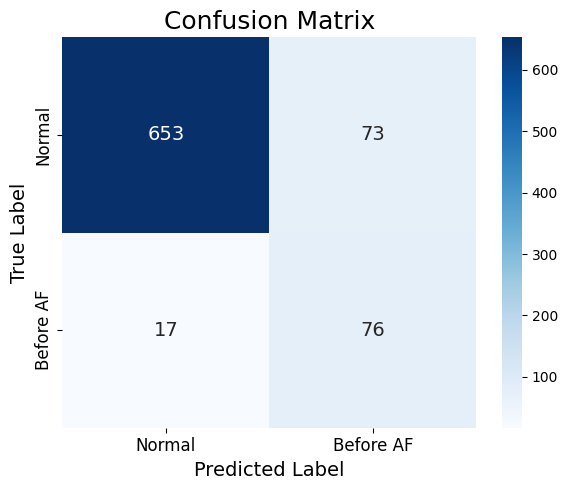

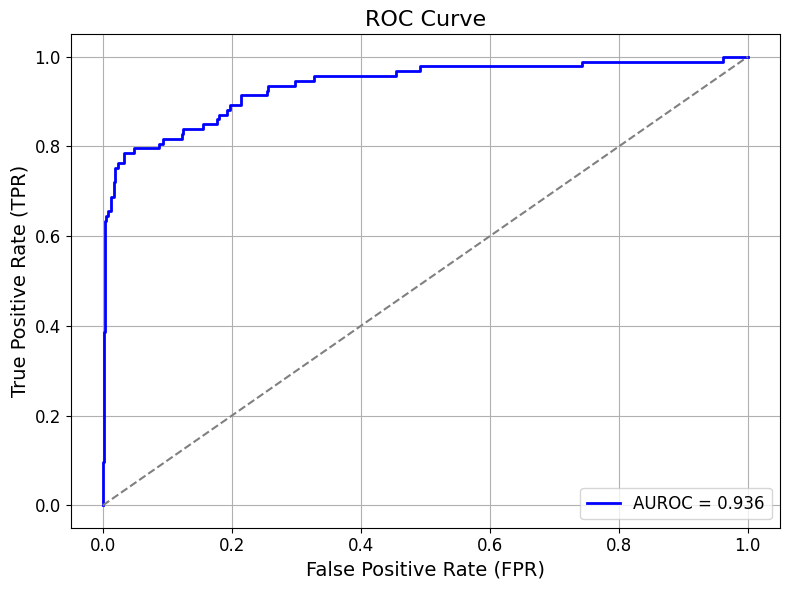

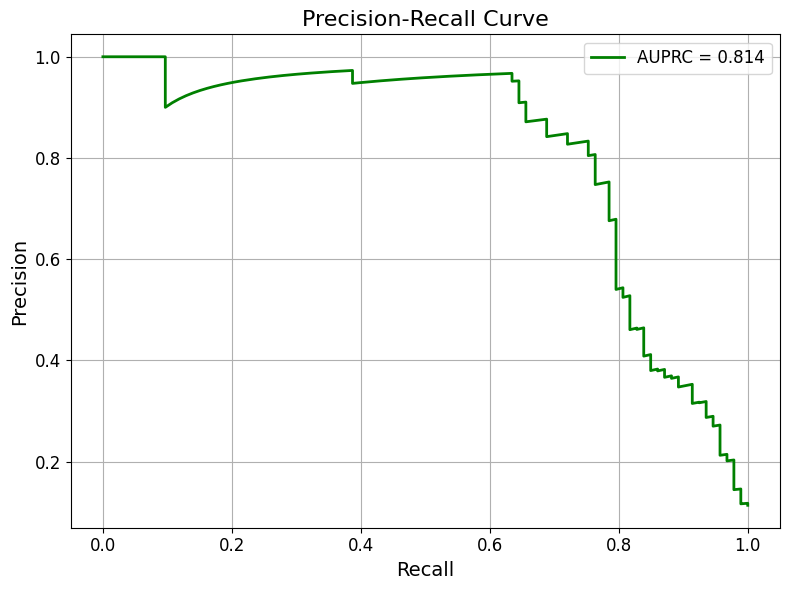

In [14]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, Dense, Dropout,
    Add, Bidirectional, LSTM
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping

def residual_block_newrri(inputs, filters=32, kernel_size=3, dropout_rate=0.2):
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding="same")(x)
    x = BatchNormalization()(x)

    shortcut = Conv1D(filters=filters, kernel_size=kernel_size, padding="same")(inputs)
    shortcut = BatchNormalization()(shortcut)

    output = Add()([x, shortcut])
    output = ReLU()(output)

    return output

def build_newrri_model(input_shape=(600, 1)):

    inputs = Input(shape=input_shape)

    x = Conv1D(filters=16, kernel_size=11, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = residual_block_newrri(x, filters=32, kernel_size=3, dropout_rate=0.2)
    x = residual_block_newrri(x, filters=32, kernel_size=3, dropout_rate=0.2)
    x = residual_block_newrri(x, filters=64, kernel_size=3, dropout_rate=0.2)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(128))(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

def subject_split(data, label, subject, val_size=0.2, test_size=0.2, seed=42):
    unique_subjects = np.unique(subject)
    train_subj, temp_subj = train_test_split(unique_subjects, test_size=(val_size + test_size), random_state=seed, shuffle=True)
    val_subj, test_subj = train_test_split(temp_subj, test_size=test_size / (val_size + test_size), random_state=seed, shuffle=True)

    train_idx = np.isin(subject, train_subj)
    val_idx = np.isin(subject, val_subj)
    test_idx = np.isin(subject, test_subj)

    return {
        'train': (data[train_idx], label[train_idx], subject[train_idx]),
        'val': (data[val_idx], label[val_idx], subject[val_idx]),
        'test': (data[test_idx], label[test_idx], subject[test_idx]),
    }

seed = 79
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Load .mat data (Preprocessed by matlab)
data_path = os.path.join(os.getcwd(), 'Data/data_RRI_short_term_10min_final.mat')
data = loadmat(data_path)

# Load all datasets
datasets = [
    {'data': data['train_data'], 'label': data['train_label'].flatten()},
    {'data': data['train2_data'], 'label': data['train2_label'].flatten()},
    {'data': data['train3_data'], 'label': data['train3_label'].flatten()},
    {'data': data['train4_data'], 'label': data['train4_label'].flatten(), 'subject': data['train4_subject'].flatten()},
    {'data': data['train5_data'], 'label': data['train5_label'].flatten(), 'subject': data['train5_subject'].flatten()},
]

# Split train4 and train5 subject-wise
split_train4 = subject_split(datasets[3]['data'], datasets[3]['label'], datasets[3]['subject'], val_size=0.2, test_size=0.2, seed=seed)
split_train5 = subject_split(datasets[4]['data'], datasets[4]['label'], datasets[4]['subject'], val_size=0.2, test_size=0.2, seed=seed)

# Save subject numbers
val_subjects = np.unique(np.concatenate([split_train4['val'][2], split_train5['val'][2]]))
test_subjects = np.unique(np.concatenate([split_train4['test'][2], split_train5['test'][2]]))

# Final splits
train_data = np.concatenate([
    datasets[0]['data'],
    datasets[1]['data'],
    datasets[2]['data'],
    split_train4['train'][0],
    split_train5['train'][0]
], axis=0)
train_label = np.concatenate([
    datasets[0]['label'],
    datasets[1]['label'],
    datasets[2]['label'],
    split_train4['train'][1],
    split_train5['train'][1]
], axis=0)

val_data = np.concatenate([split_train4['val'][0], split_train5['val'][0]], axis=0)
val_label = np.concatenate([split_train4['val'][1], split_train5['val'][1]], axis=0)

test_data = np.concatenate([split_train4['test'][0], split_train5['test'][0]], axis=0)
test_label = np.concatenate([split_train4['test'][1], split_train5['test'][1]], axis=0)

# Debug Train and Val
print("Train:", train_data.shape)
print("Val:", val_data.shape)
print("Test:", test_data.shape)

# Upsample the training data
ros = RandomOverSampler(random_state=seed)
x_train_final, y_train_final = ros.fit_resample(train_data, train_label)

# Reshape for train
x_train_final = x_train_final.reshape((-1, 600, 1))
x_valid = val_data.reshape((-1, 600, 1))
x_test = test_data.reshape((-1, 600, 1))
y_test = test_label
y_valid = val_label

# Build and compile the model
model = build_newrri_model(input_shape=(600, 1))

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
# history = model.fit(
#     x_train_final, y_train_final,
#     validation_data=(x_valid, y_valid),
#     epochs=300,
#     batch_size=32,
#     verbose=1,
#     callbacks=[early_stopping],
#     shuffle=True
# )

model.load_weights('Models/model_10min_final.h5')

# Save the final trained model
# np.savez(f'Models/data_10min_final.npz',
#          X_train=x_train_final,
#          y_train=y_train_final,
#          val_subjects=val_subjects,
#          test_subjects=test_subjects,
#          X_valid=x_valid,
#          y_valid=y_valid,
#          X_test=x_test,
#          y_test=y_test)
# model.save(f'Models/model_10min_final.h5')

# Predict probabilities on validation set
val_prob = model.predict(x_valid)
val_scores = val_prob[:, 1]
val_true = y_valid

# Predict probabilities on test set
y_prob = model.predict(x_test)
y_scores = y_prob[:, 1]
y_true = y_test

fpr, tpr, roc_thresholds = roc_curve(val_true, val_scores)
youden_j = tpr - fpr
best_roc_idx = np.argmax(youden_j)
best_threshold = roc_thresholds[best_roc_idx]

print(f"Best threshold: {best_threshold:.4f}")

# Apply best threshold from validation
y_pred = (y_scores >= best_threshold).astype(int)

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_true, y_scores)
auprc = auc(rec, prec)

# Metrics
sensitivity = recall_score(y_true, y_pred)
specificity = recall_score(y_true, y_pred, pos_label=0)
precision_val = precision_score(y_true, y_pred)
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Accuracy Matrix
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"AUPRC: {auprc:.4f}")
print(f"AUROC: {roc_auc:.4f}")

# Classification Report
print(classification_report(y_true, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
ax = sns.heatmap(confusion_matrix(y_true, y_pred),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Before AF'],
                yticklabels=['Normal', 'Before AF'],
                annot_kws={"size": 14})
ax.set_title("Confusion Matrix", fontsize=18)
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()


# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUROC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('ROC Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

# AUPRC
plt.figure(figsize=(8, 6))
plt.plot(rec, prec, color='green', lw=2, label=f'AUPRC = {auprc:.3f}')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()


5 Minutes window Training and Evaluation

Train: (6436, 300)
Val: (1632, 300)
Test: (1638, 300)
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
Best threshold: 0.0087
Sensitivity (Recall): 0.8978
Specificity: 0.7658
Precision: 0.3294
F1 Score (weighted): 0.8180
AUPRC: 0.7075
AUROC: 0.9101
              precision    recall  f1-score   support

           0       0.98      0.77      0.86      1452
           1       0.33      0.90      0.48       186

    accuracy                           0.78      1638
   macro avg       0.66      0.83      0.67      1638
weighted avg       0.91      0.78      0.82      1638



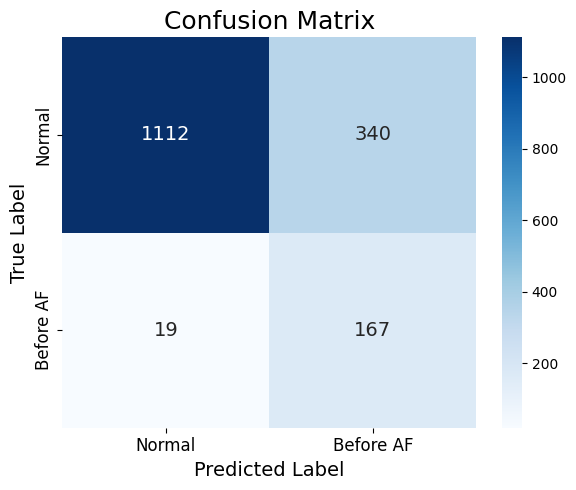

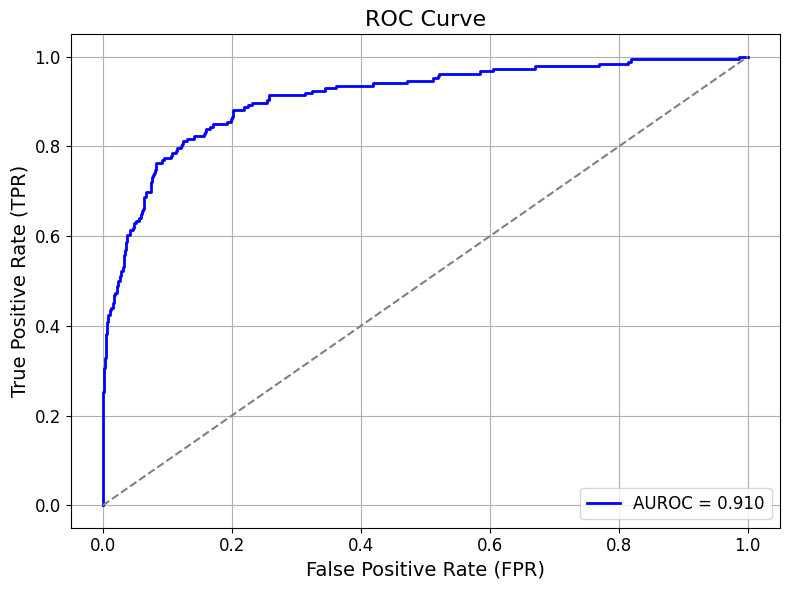

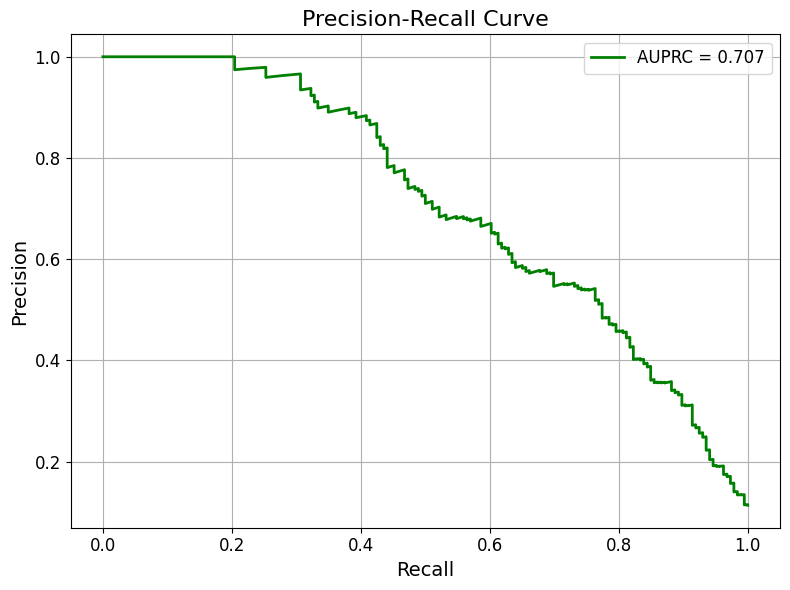

In [11]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, Dense, Dropout,
    Add, Bidirectional, LSTM
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping

def residual_block_newrri(inputs, filters=32, kernel_size=3, dropout_rate=0.2):
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding="same")(x)
    x = BatchNormalization()(x)

    shortcut = Conv1D(filters=filters, kernel_size=kernel_size, padding="same")(inputs)
    shortcut = BatchNormalization()(shortcut)

    output = Add()([x, shortcut])
    output = ReLU()(output)

    return output

def build_newrri_model(input_shape=(600, 1)):

    inputs = Input(shape=input_shape)

    x = Conv1D(filters=16, kernel_size=11, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = residual_block_newrri(x, filters=32, kernel_size=3, dropout_rate=0.2)
    x = residual_block_newrri(x, filters=32, kernel_size=3, dropout_rate=0.2)
    x = residual_block_newrri(x, filters=64, kernel_size=3, dropout_rate=0.2)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(128))(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

def subject_split(data, label, subject, val_size=0.2, test_size=0.2, seed=42):
    unique_subjects = np.unique(subject)
    train_subj, temp_subj = train_test_split(unique_subjects, test_size=(val_size + test_size), random_state=seed, shuffle=True)
    val_subj, test_subj = train_test_split(temp_subj, test_size=test_size / (val_size + test_size), random_state=seed, shuffle=True)

    train_idx = np.isin(subject, train_subj)
    val_idx = np.isin(subject, val_subj)
    test_idx = np.isin(subject, test_subj)

    return {
        'train': (data[train_idx], label[train_idx], subject[train_idx]),
        'val': (data[val_idx], label[val_idx], subject[val_idx]),
        'test': (data[test_idx], label[test_idx], subject[test_idx]),
    }

seed = 79
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Load .mat data (Preprocessed by matlab)
data_path = os.path.join(os.getcwd(), 'Data/data_RRI_short_term_5min_final.mat')
data = loadmat(data_path)

# Load all datasets
datasets = [
    {'data': data['train_data'], 'label': data['train_label'].flatten()},
    {'data': data['train2_data'], 'label': data['train2_label'].flatten()},
    {'data': data['train3_data'], 'label': data['train3_label'].flatten()},
    {'data': data['train4_data'], 'label': data['train4_label'].flatten(), 'subject': data['train4_subject'].flatten()},
    {'data': data['train5_data'], 'label': data['train5_label'].flatten(), 'subject': data['train5_subject'].flatten()},
]

# Split train4 and train5 subject-wise
split_train4 = subject_split(datasets[3]['data'], datasets[3]['label'], datasets[3]['subject'], val_size=0.2, test_size=0.2, seed=seed)
split_train5 = subject_split(datasets[4]['data'], datasets[4]['label'], datasets[4]['subject'], val_size=0.2, test_size=0.2, seed=seed)

# Save subject numbers
val_subjects = np.unique(np.concatenate([split_train4['val'][2], split_train5['val'][2]]))
test_subjects = np.unique(np.concatenate([split_train4['test'][2], split_train5['test'][2]]))

# Final splits
train_data = np.concatenate([
    datasets[0]['data'],
    datasets[1]['data'],
    datasets[2]['data'],
    split_train4['train'][0],
    split_train5['train'][0]
], axis=0)
train_label = np.concatenate([
    datasets[0]['label'],
    datasets[1]['label'],
    datasets[2]['label'],
    split_train4['train'][1],
    split_train5['train'][1]
], axis=0)

val_data = np.concatenate([split_train4['val'][0], split_train5['val'][0]], axis=0)
val_label = np.concatenate([split_train4['val'][1], split_train5['val'][1]], axis=0)

test_data = np.concatenate([split_train4['test'][0], split_train5['test'][0]], axis=0)
test_label = np.concatenate([split_train4['test'][1], split_train5['test'][1]], axis=0)

# Debug Train and Val
print("Train:", train_data.shape)
print("Val:", val_data.shape)
print("Test:", test_data.shape)

# Upsample the training data
ros = RandomOverSampler(random_state=seed)
x_train_final, y_train_final = ros.fit_resample(train_data, train_label)

# Reshape for train
x_train_final = x_train_final.reshape((-1, 300, 1))
x_valid = val_data.reshape((-1, 300, 1))
x_test = test_data.reshape((-1, 300, 1))
y_test = test_label
y_valid = val_label

# Build and compile the model
model = build_newrri_model(input_shape=(300, 1))

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
# history = model.fit(
#     x_train_final, y_train_final,
#     validation_data=(x_valid, y_valid),
#     epochs=300,
#     batch_size=32,
#     verbose=1,
#     callbacks=[early_stopping],
#     shuffle=True
# )

model.load_weights('Models/model_5min_final.h5')

# Save the final trained model
# np.savez(f'Models/data_5min_final.npz',
#          X_train=x_train_final,
#          y_train=y_train_final,
#          val_subjects=val_subjects,
#          test_subjects=test_subjects,
#          X_valid=x_valid,
#          y_valid=y_valid,
#          X_test=x_test,
#          y_test=y_test)
# model.save(f'Models/model_5min_final.h5')


# Predict probabilities on validation set
val_prob = model.predict(x_valid)
val_scores = val_prob[:, 1]
val_true = y_valid

# Predict probabilities on test set
y_prob = model.predict(x_test)
y_scores = y_prob[:, 1]
y_true = y_test

fpr, tpr, roc_thresholds = roc_curve(val_true, val_scores)
youden_j = tpr - fpr
best_roc_idx = np.argmax(youden_j)
best_threshold = roc_thresholds[best_roc_idx]

print(f"Best threshold: {best_threshold:.4f}")

# Apply best threshold from validation
y_pred = (y_scores >= best_threshold).astype(int)

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_true, y_scores)
auprc = auc(rec, prec)

# Metrics
sensitivity = recall_score(y_true, y_pred)
specificity = recall_score(y_true, y_pred, pos_label=0)
precision_val = precision_score(y_true, y_pred)
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Accuracy Matrix
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"AUPRC: {auprc:.4f}")
print(f"AUROC: {roc_auc:.4f}")

# Classification Report
print(classification_report(y_true, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
ax = sns.heatmap(confusion_matrix(y_true, y_pred),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Before AF'],
                yticklabels=['Normal', 'Before AF'],
                annot_kws={"size": 14})
ax.set_title("Confusion Matrix", fontsize=18)
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()


# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUROC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('ROC Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

# AUPRC
plt.figure(figsize=(8, 6))
plt.plot(rec, prec, color='green', lw=2, label=f'AUPRC = {auprc:.3f}')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

AUROC and AUPRC comparison


Processing 30min...


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step
AUROC: 0.9103, AUPRC: 0.7367

Processing 15min...


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
AUROC: 0.9189, AUPRC: 0.8108

Processing 10min...


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
AUROC: 0.9361, AUPRC: 0.8141

Processing 5min...


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
AUROC: 0.9101, AUPRC: 0.7075


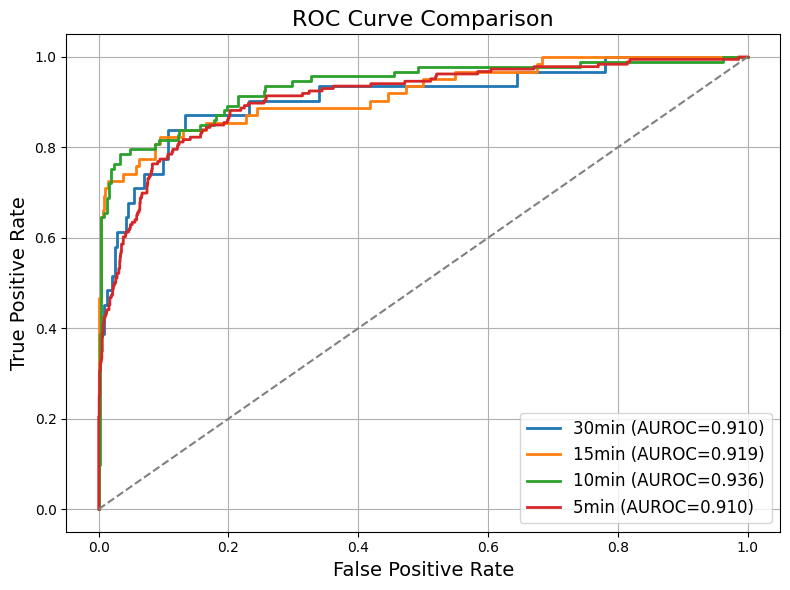

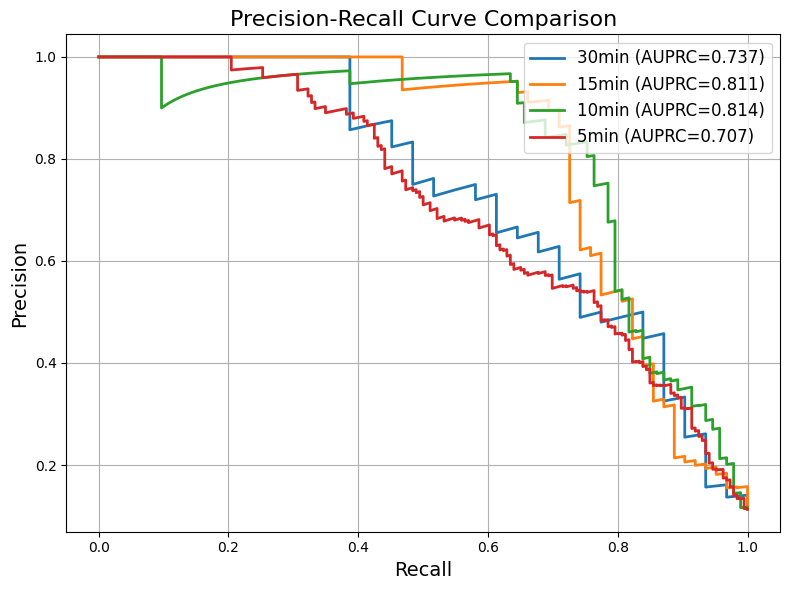


=== Summary ===
30min: AUROC = 0.9103, AUPRC = 0.7367
15min: AUROC = 0.9189, AUPRC = 0.8108
10min: AUROC = 0.9361, AUPRC = 0.8141
5min: AUROC = 0.9101, AUPRC = 0.7075


In [10]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from tensorflow.keras.models import load_model

# Folder paths for your results
time_intervals = ['30min', '15min', '10min', '5min']
base_path = 'Models/'

# Store results and curves
results = {}
roc_curves = {}
pr_curves = {}

for interval in time_intervals:
    print(f"\nProcessing {interval}...")

    # Load dataset and model
    data = np.load(os.path.join(base_path, f'data_{interval}_final.npz'))
    model = load_model(os.path.join(base_path, f'model_{interval}_final.h5'))

    X_test = data['X_test']
    y_test = data['y_test']

    y_prob = model.predict(X_test)

    if y_prob.shape[-1] == 2:
        y_scores = y_prob[:, 1]
    else:
        y_scores = y_prob.flatten()

    # ROC and PR curves
    fpr, tpr, _ = roc_curve(y_test, y_scores,drop_intermediate=False)
    prec, rec, _ = precision_recall_curve(y_test, y_scores,drop_intermediate=False)

    roc_auc = auc(fpr, tpr)
    auprc = auc(rec, prec)

    # Save results
    results[interval] = {'AUROC': roc_auc, 'AUPRC': auprc}
    roc_curves[interval] = (fpr, tpr)
    pr_curves[interval] = (rec, prec)

    print(f"AUROC: {roc_auc:.4f}, AUPRC: {auprc:.4f}")

# Combined AUROC
plt.figure(figsize=(8, 6))
for interval in time_intervals:
    fpr, tpr = roc_curves[interval]
    roc_auc = results[interval]['AUROC']
    plt.plot(fpr, tpr, lw=2, label=f'{interval} (AUROC={roc_auc:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve Comparison', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

# Combined AUPRC
plt.figure(figsize=(8, 6))
for interval in time_intervals:
    rec, prec = pr_curves[interval]
    auprc = results[interval]['AUPRC']
    plt.plot(rec, prec, lw=2, label=f'{interval} (AUPRC={auprc:.3f})')

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve Comparison', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

# Final summary
print("\n=== Summary ===")
for interval, metrics in results.items():
    print(f"{interval}: AUROC = {metrics['AUROC']:.4f}, AUPRC = {metrics['AUPRC']:.4f}")


Up to 3 hours before AF onset train and validation for Section V-B

Train: (2987, 600)
Val: (555, 600)
Test: (552, 600)
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Best threshold: 0.1511
Sensitivity (Recall): 0.9333
Specificity: 0.8788
Precision: 0.6000
F1 Score (weighted): 0.8967
AUPRC: 0.9210
AUROC: 0.9643
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       462
           1       0.60      0.93      0.73        90

    accuracy                           0.89       552
   macro avg       0.79      0.91      0.83       552
weighted avg       0.92      0.89      0.90       552



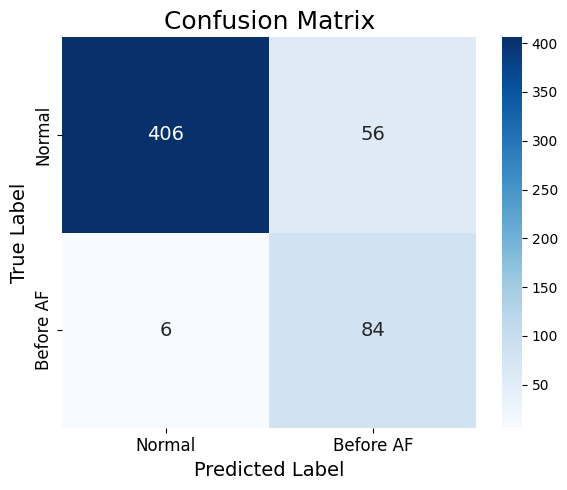

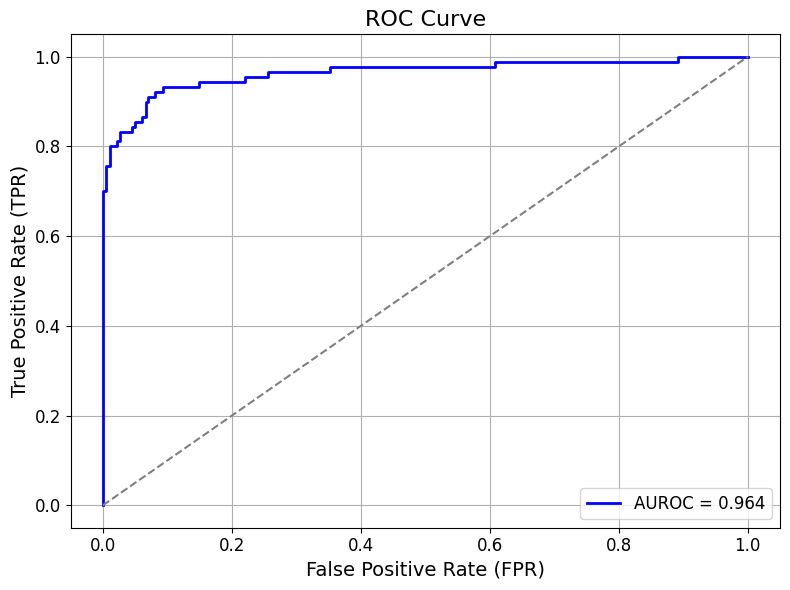

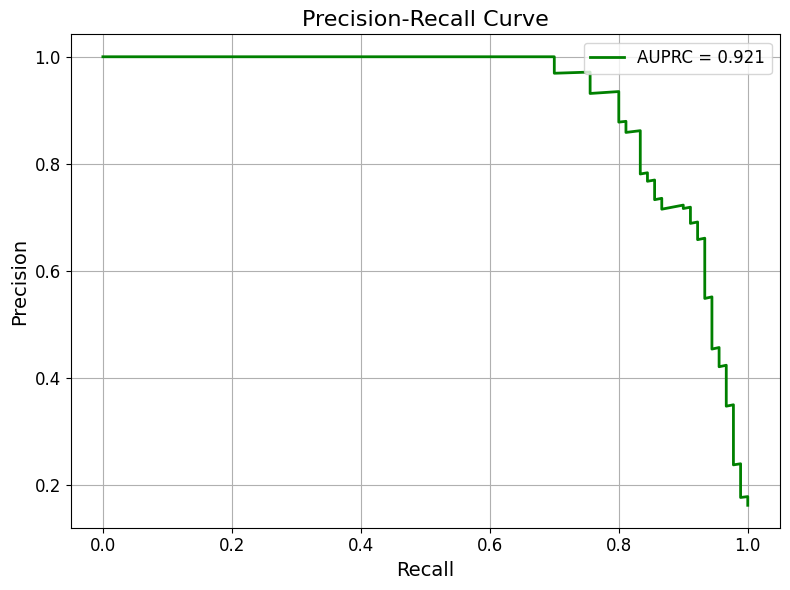

In [9]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, Dense, Dropout,
    Add, Bidirectional, LSTM
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping

def residual_block_newrri(inputs, filters=32, kernel_size=3, dropout_rate=0.2):
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding="same")(x)
    x = BatchNormalization()(x)

    shortcut = Conv1D(filters=filters, kernel_size=kernel_size, padding="same")(inputs)
    shortcut = BatchNormalization()(shortcut)

    output = Add()([x, shortcut])
    output = ReLU()(output)

    return output

def build_newrri_model(input_shape=(600, 1)):

    inputs = Input(shape=input_shape)

    x = Conv1D(filters=16, kernel_size=11, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = residual_block_newrri(x, filters=32, kernel_size=3, dropout_rate=0.2)
    x = residual_block_newrri(x, filters=32, kernel_size=3, dropout_rate=0.2)
    x = residual_block_newrri(x, filters=64, kernel_size=3, dropout_rate=0.2)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(128))(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

def subject_split(data, label, subject, val_size=0.2, test_size=0.2, seed=42):
    unique_subjects = np.unique(subject)
    train_subj, temp_subj = train_test_split(unique_subjects, test_size=(val_size + test_size), random_state=seed, shuffle=True)
    val_subj, test_subj = train_test_split(temp_subj, test_size=test_size / (val_size + test_size), random_state=seed, shuffle=True)

    train_idx = np.isin(subject, train_subj)
    val_idx = np.isin(subject, val_subj)
    test_idx = np.isin(subject, test_subj)

    return {
        'train': (data[train_idx], label[train_idx], subject[train_idx]),
        'val': (data[val_idx], label[val_idx], subject[val_idx]),
        'test': (data[test_idx], label[test_idx], subject[test_idx]),
    }

seed = 79
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Load .mat data (Preprocessed by matlab)
data_path = os.path.join(os.getcwd(), 'Data/data_RRI_short_term_final_3h.mat')
data = loadmat(data_path)

# Load all datasets
datasets = [
    {'data': data['train_data'], 'label': data['train_label'].flatten()},
    {'data': data['train2_data'], 'label': data['train2_label'].flatten()},
    {'data': data['train3_data'], 'label': data['train3_label'].flatten()},
    {'data': data['train4_data'], 'label': data['train4_label'].flatten(), 'subject': data['train4_subject'].flatten()},
    {'data': data['train5_data'], 'label': data['train5_label'].flatten(), 'subject': data['train5_subject'].flatten()},
]

# Split train4 and train5 subject-wise
split_train4 = subject_split(datasets[3]['data'], datasets[3]['label'], datasets[3]['subject'], val_size=0.2, test_size=0.2, seed=seed)
split_train5 = subject_split(datasets[4]['data'], datasets[4]['label'], datasets[4]['subject'], val_size=0.2, test_size=0.2, seed=seed)

# Save subject numbers
val_subjects = np.unique(np.concatenate([split_train4['val'][2], split_train5['val'][2]]))
test_subjects = np.unique(np.concatenate([split_train4['test'][2], split_train5['test'][2]]))

# Final splits
train_data = np.concatenate([
    datasets[0]['data'],
    datasets[1]['data'],
    datasets[2]['data'],
    split_train4['train'][0],
    split_train5['train'][0]
], axis=0)
train_label = np.concatenate([
    datasets[0]['label'],
    datasets[1]['label'],
    datasets[2]['label'],
    split_train4['train'][1],
    split_train5['train'][1]
], axis=0)

val_data = np.concatenate([split_train4['val'][0], split_train5['val'][0]], axis=0)
val_label = np.concatenate([split_train4['val'][1], split_train5['val'][1]], axis=0)

test_data = np.concatenate([split_train4['test'][0], split_train5['test'][0]], axis=0)
test_label = np.concatenate([split_train4['test'][1], split_train5['test'][1]], axis=0)

# Debug Train and Val
print("Train:", train_data.shape)
print("Val:", val_data.shape)
print("Test:", test_data.shape)

# Upsample the training data
ros = RandomOverSampler(random_state=seed)
x_train_final, y_train_final = ros.fit_resample(train_data, train_label)

# Reshape if necessary
x_train_final = x_train_final.reshape((-1, 600, 1))
x_valid = val_data.reshape((-1, 600, 1))
x_test = test_data.reshape((-1, 600, 1))
y_test = test_label
y_valid = val_label

# Build and compile the model
model = build_newrri_model(input_shape=(600, 1))

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
# history = model.fit(
#     x_train_final, y_train_final,
#     validation_data=(x_valid, y_valid),
#     epochs=300,
#     batch_size=32,
#     verbose=1,
#     callbacks=[early_stopping]
# )

model.load_weights('Models/model_final_3h.h5')

# Save the final trained model
# np.savez(f'Models/data_final_3h.npz',
#          X_train=x_train_final,
#          y_train=y_train_final,
#          val_subjects=val_subjects,
#          test_subjects=test_subjects,
#          X_valid=x_valid,
#          y_valid=y_valid,
#          X_test=x_test,
#          y_test=y_test)
# model.save(f'Models/model_final_3h.h5')

# Predict probabilities on validation set
val_prob = model.predict(x_valid)
val_scores = val_prob[:, 1]
val_true = y_valid

# Predict probabilities on test set
y_prob = model.predict(x_test)
y_scores = y_prob[:, 1]
y_true = y_test

fpr, tpr, roc_thresholds = roc_curve(val_true, val_scores)
youden_j = tpr - fpr
best_roc_idx = np.argmax(youden_j)
best_threshold = roc_thresholds[best_roc_idx]

print(f"Best threshold: {best_threshold:.4f}")

# Apply best threshold from validation
y_pred = (y_scores >= best_threshold).astype(int)

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_true, y_scores)
auprc = auc(rec, prec)

# Metrics
sensitivity = recall_score(y_true, y_pred)
specificity = recall_score(y_true, y_pred, pos_label=0)
precision_val = precision_score(y_true, y_pred)
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Accuracy Matrix
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"AUPRC: {auprc:.4f}")
print(f"AUROC: {roc_auc:.4f}")

# Classification Report
print(classification_report(y_true, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
ax = sns.heatmap(confusion_matrix(y_true, y_pred),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Before AF'],
                yticklabels=['Normal', 'Before AF'],
                annot_kws={"size": 14})
ax.set_title("Confusion Matrix", fontsize=18)
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()


# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUROC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('ROC Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

# AUPRC
plt.figure(figsize=(8, 6))
plt.plot(rec, prec, color='green', lw=2, label=f'AUPRC = {auprc:.3f}')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()